# Explanatory Notebook


*Notebook for the paper [Conditionally Elicitable Dynamic Risk Measures for Deep Reinforcement Learning](https://papers.ssrn.com/sol3/papers.cfm?abstract_id=4149461), by [Anthony Coache](https://anthonycoache.ca/), [Sebastian Jaimungal](http://sebastian.statistics.utoronto.ca/) and [Álvaro Cartea](https://sites.google.com/site/alvarocartea/home).*

This Jupyter notebook showcases how to use the Python files for using our proposed actor-critic algorithm and reproducing some of the main figures in the portfolio allocation example, i.e. the case where price dynamics follow mean-reversion patterns. All the Python code and modules are publicly available in the [Github repository](https://github.com/acoache/RL-ElicitableDynamicRisk).

## 1. Importation of Python libraries

We load some basics Python libraries, such as NumPy, PyTorch, SciPy and Matplotlib.

In [1]:
# numpy
import numpy as np
# plotting
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
# pytorch
import torch as T
# misc
from time import time

We also load the different classes and functions in our Python modules. We refer the user to the Python files for a description of every function in the modules. Furthermore, the user can modify these files to solve other RL problems.

In [2]:
# personal modules
from PortfolioAllocation.utils import directory, cmap, colors, rainbow # colors
from PortfolioAllocation.hyperparams import init_params, print_params # hyperparameters
from PortfolioAllocation.models import PolicyANN, VaRANN, DiffCVaRANN # ANN structures
from PortfolioAllocation.risk_measures import RiskMeasure # risk measure instance
from PortfolioAllocation.envs_meanrevert import Environment # environment
from PortfolioAllocation.agents import Agent # actor-critic algorithm

## 2. Initialisation of training hyperparameters

We first modify the hyperparameters related to the environment and actor-critic algorithm in the file called **hyperparams.py**. We also specify how frequently we want to diagnose the training process and save our models.

In [3]:
_, env_params, algo_params = init_params() # all hyperparameters
repo = "data_TrainedModels" # name of the directory
print_progress = 200 # number of epochs before printing the time/loss
plot_progress = 200 # number of epochs before diagnostic plots
save_progress = 200 # number of epochs before saving the models

We add the threshold of the conditional value-at-risk (CVaR) we want to use. Note that we can specify more than one threshold in the **main_training.py** file -- we use a single one here for illustrative purposes.

In [4]:
alpha_cvar = 0.5 # threshold for the dynamic CVaR

We create labels for the names of our repositories and figures.

In [5]:
rm_label = 'CVaR' + str( round(alpha_cvar, 3) )

# create (sub)folders to store results
directory(repo)
directory(repo + '/' + rm_label)
directory(repo + '/' + rm_label + '/evolution')

Before starting the training phase, we make sure that all hyperparameters are correct by printing them in the console.

In [6]:
print('##### Name of the repository: ', repo, ' #####')
print_params(env_params, algo_params)
print('#####   Risk measure: ', rm_label, '   #####')

##### Name of the repository:  data_TrainedModels  #####
*  mu:  [0.03 0.06 0.09] 
   sigma:  [0.06 0.12 0.18] 
   rho:  [[1.  0.2 0.2]
 [0.2 1.  0.2]
 [0.2 0.2 1. ]] 
   S0:  [1. 1. 1.]  r0:  0.0  x0:  1  T:  1  dt:  0.08333333333333333
*  Ntrajectories:  10000  Nepochs:  2000
*  Nepochs_V_init:  2000  Nepochs_V:  1000  replace_target:  300  lr_V:  0.005  batch_V:  1000  hidden_V:  16  layers_V:  4
*  Nepochs_pi:  10  lr_pi:  0.005  batch_pi:  1000  hidden_pi:  16  layers_pi:  4
#####   Risk measure:  CVaR0.5    #####


We instantiate the environment from the **env.py** file to get functions to interact with the data-generating process, as well as the risk measure from the **risk_measure.py** file to compute the appropriate strictly consistent scoring function.

In [7]:
env = Environment(env_params) # environment
risk_measure = RiskMeasure(alpha=alpha_cvar, C=10.0) # risk measure

## 3. Training of risk-aware agents

We initialise the different neural network structures for our algorithm from the **models.py** file. We have respectively:
- an ANN representing the policy $\pi^{\theta}$;
- two ANNs for the value-at-risk (VaR) $H_1^{\psi_1}, H_1^{\tilde{\psi_1}}$ (i.e. main and target networks);
- two ANNs for the difference between CVaR and VaR $H_2^{\psi_2}, H_2^{\tilde{\psi_2}}$ (i.e. main and target networks).

In [8]:
# create ANNs for policy, VaR and DiffCVaR
policy = PolicyANN(input_size=1+len(env.S0),
                    hidden_size=algo_params["hidden_pi"],
                    n_layers=algo_params["layers_pi"],
                    env=env,
                    learn_rate=algo_params["lr_pi"])
VaR_main = VaRANN(input_size=1+len(env.S0),
                hidden_size=algo_params["hidden_V"],
                n_layers=algo_params["layers_V"],
                env=env,
                learn_rate=algo_params["lr_V"])
VaR_target = VaRANN(input_size=1+len(env.S0),
                hidden_size=algo_params["hidden_V"],
                n_layers=algo_params["layers_V"],
                env=env,
                learn_rate=algo_params["lr_V"])
DiffCVaR_main = DiffCVaRANN(input_size=1+len(env.S0),
                            hidden_size=algo_params["hidden_V"],
                            n_layers=algo_params["layers_V"],
                            env=env,
                            learn_rate=algo_params["lr_V"])
DiffCVaR_target = DiffCVaRANN(input_size=1+len(env.S0),
                            hidden_size=algo_params["hidden_V"],
                            n_layers=algo_params["layers_V"],
                            env=env,
                            learn_rate=algo_params["lr_V"])

We instantiate our risk-aware agent from the **agents_py** file with the objects described above. This class regroups the different routines to solve our optimisation problem.

In [9]:
actor_critic = Agent(env=env, # environment
                    risk_measure=risk_measure, # risk measure
                    policy=policy, # policy
                    VaR_main=VaR_main, # VaR
                    VaR_target=VaR_target, # target VaR
                    DiffCVaR_main=DiffCVaR_main, # difference between CVaR and VaR
                    DiffCVaR_target=DiffCVaR_target) # target difference between CVaR and VaR

We next start the training phase of our actor-critic algorithm -- this corresponds to the Algorithm 1 presented in our [paper](https://papers.ssrn.com/sol3/papers.cfm?abstract_id=4149461). We perform the optimisation by alternating between

1. Estimation of the value function $V^{\psi}$ for the current policy $\pi^{\theta}$, using a strictly consistent scoring function $S$;
2. Update of the policy $\pi^{\theta}$, using a policy gradient method.

Every now and then, we save our progress and create diagnostic figures to see the evolution of the models being trained. Note that for this illustrative notebook, we do not run this code in the Jupyter notebook. However, we provide trained models in the Github repository.

In [ ]:
# time the algorithm
start_time = time()

# first estimate of the value function
actor_critic.estimate_V(Ntrajectories=algo_params["Ntrajectories"],
                        Nminibatch=algo_params["batch_V"],
                        Nepochs=algo_params["Nepochs_V_init"],
                        replace_target=algo_params["replace_target"],
                        init_lr=algo_params["lr_V"])

for epoch in range(algo_params["Nepochs"]):
    # estimate the value function of the current policy (critic)
    actor_critic.estimate_V(Ntrajectories=algo_params["Ntrajectories"],
                            Nminibatch=algo_params["batch_V"],
                            Nepochs=algo_params["Nepochs_V"],
                            replace_target=algo_params["replace_target"],
                            init_lr=2e-3)

    # update the policy by policy gradient (actor)
    actor_critic.update_policy(Nminibatch=int(algo_params["batch_pi"]/(1-alpha_cvar)),
                                Nepochs=algo_params["Nepochs_pi"],
                                min_lr=3e-4)

    # plot current policy
    if epoch % plot_progress == 0 or epoch == algo_params["Nepochs"] - 1:
        actor_critic.plot_current_policy(repo + '/' + rm_label + '/evolution')
        # actor_critic.plot_current_V(repo + '/' + rm_label + '/evolution')

    # save progress
    if epoch % save_progress == 0:
        actor_critic.save_models(repo + '/' + rm_label + '/evolution')
    
    # print progress
    if epoch % print_progress == 0 or epoch == algo_params["Nepochs"] - 1:
        print('*** Epoch = ', str(epoch) ,
                ' completed, Duration = ', "{:.2f}".format((time() - start_time)/60), ' mins ***')
        print('Estimation of V -- Loss: ', str(np.round( np.mean(actor_critic.loss_history_V[-actor_critic.loss_trail_V:]) , 7)))
        print('Update of pi -- Loss: ', str(np.round( np.mean(actor_critic.loss_history_pi[-actor_critic.loss_trail_pi:]) ,5)),
                  ', lr: ', str(np.round( actor_critic.policy.optimizer.param_groups[0]['lr'] , 5)))
        start_time = time()

We save the optimal ANNs for the policy and value function in a certain folder, in order to reuse them in another session. Usually, the training phase would be executed on a different server than the testing phase, which is why saving our models is a crucial step.

In [ ]:
actor_critic.save_models(repo + '/' + rm_label)

## 4. Initialisation of testing parameters

We set up hyperparameters for the testing phase, such as the number of replications and the seed for the random number generator. If the training phase was performed on an external server, we must initialise the hyperparameters and instantiate the simulation engine representing the environment, i.e. run sections 1 and 2 of the Jupyter notebook.

In [10]:
seed = 4321 # set seed for replication purposes
Nsimulations = 30_000 # number of simulations following the optimal strategy

## 5. Testing of risk-aware agents

If one assumes the models were executed on an external server, we must create placeholders for the ANNs and store them in the actor-critic module. We then load the learned models in our agent object.

In [11]:
actor_critic.load_models(repo + '/' + rm_label)
actor_critic.set_train_mode(train=False)

### 5.1 Learnt optimal policy

We investigate the exact behavior of the risk-aware agent at every state and every period $t=0,\ldots,T-1$ by plotting the optimal policy as a function of the asset prices $S_{t}^{(i)}, \, i=1,2,3$. In this specific plot, the $x$-axis is the price of the first asset $S_{0}^{(1)}$, the $y$-axis the price of the second asset $S_{0}^{(2)}$, and we vary the price of the third asset $S_{0}^{(3)}$ by columns. This corresponds to Figure 4 in our paper.

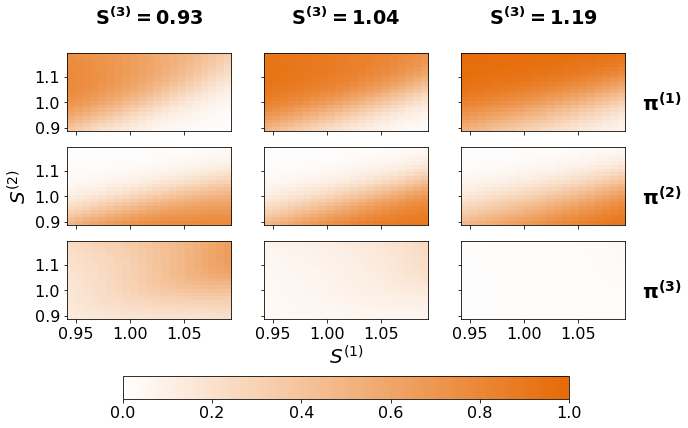

In [12]:
# figure parameters
plt.rcParams.update({'font.size': 16, 'figure.figsize': (10,7)})
plt.rc('axes', labelsize=20)
nrows = len(env.S0) 
ncols = 3
fig, axes = plt.subplots(nrows, ncols, sharey='all', sharex='all')
grid = plt.GridSpec(nrows, ncols)

# values of the price of asset 3
s3_spaces = [env.spaces["s3_space"][int((len(env.spaces["s3_space"])-1)/4)], \
            env.spaces["s3_space"][int((len(env.spaces["s3_space"])-1)/2)], \
            env.spaces["s3_space"][-int((len(env.spaces["s3_space"])-1)/4)]]

for s3_idx, s3_val in enumerate(s3_spaces):            
    # compute 2D histograms for all assets
    hist2dim_policy = T.zeros((len(env.spaces["s2_space"]), len(env.spaces["s1_space"]), len(env.S0)))
    for s2_idx, s2_val in enumerate(env.spaces["s2_space"]):
        for s1_idx, s1_val in enumerate(env.spaces["s1_space"]):
            hist2dim_policy[len(env.spaces["s2_space"])-s2_idx-1, s1_idx, :], _ = \
                    actor_critic.select_actions(env.t[0]*T.ones(1, device=actor_critic.device),
                                                T.Tensor([s1_val,s2_val,s3_val], device=actor_critic.device).unsqueeze(0),
                                                'best')
     # optimal policy for each asset                     
    for idx_asset in range(len(env.S0)):
        if s3_idx != 0:
            plt.setp(axes[idx_asset,s3_idx].get_yticklabels(), visible=False)

        temp = axes[idx_asset,s3_idx].imshow(hist2dim_policy[:,:,idx_asset].detach().numpy(),
                                interpolation='none',
                                cmap=cmap,
                                extent=[np.min(env.spaces["s1_space"]),
                                        np.max(env.spaces["s1_space"]),
                                        np.min(env.spaces["s2_space"]),
                                        np.max(env.spaces["s2_space"])],
                                aspect='auto',
                                vmin=np.min(env.spaces["action_space"]),
                                vmax=np.max(env.spaces["action_space"]))

# titles for columns
columns = []
for idx in range(len(s3_spaces)):
    columns.append(fig.add_subplot(grid[:,idx], frameon=False))
    columns[idx].set_title(r"$\mathbf{S^{(3)}=}$" + str(np.round(s3_spaces[idx], 2)) + '\n', fontweight='semibold')
    columns[idx].axis('off')

# labels for all plots
xyaxis=fig.add_subplot(grid[:,:], frameon=False)
xyaxis.set_xlabel(r"$S^{(1)}$")
xyaxis.set_ylabel(r"$S^{(2)}$")
xyaxis.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)

# titles for rows
rows = []
for idx in range(len(env.S0)):
    twin = fig.add_subplot(grid[idx,:], frameon=False)
    rows.append(twin.twinx())
    twin.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
    rows[idx].tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
    rows[idx].set_ylabel(r"$\mathbf{{ \pi^{{({:d})}} }}$".format(idx+1), fontweight='semibold', rotation=0)
    rows[idx].set_frame_on(False)

# add a common colorbar for the figure
fig.colorbar(temp, \
        ax=axes.ravel().tolist() + [xyaxis] + columns + rows, \
        orientation='horizontal', shrink=0.8)
plt.show()

### 5.2 Distribution of P&L

We explore the distribution of the P&L when the agent follows the learnt optimal policy. To do so, we run several full episodes following the learnt policy, and keep track of the costs observed by the agent.

In [13]:
pretrained_agents = ['CVaR0.05', 'CVaR0.25', 'CVaR0.5', 'CVaR0.7']
x_paths = np.zeros((Nsimulations, len(env.t), len(pretrained_agents)))

for idx, label in enumerate(pretrained_agents):

    # load models
    actor_critic.load_models(repo + '/' + label)
    actor_critic.set_train_mode(train=False)
    
    # set seed for reproducibility purposes
    T.manual_seed(seed)
    np.random.seed(seed)
    
    # simulate episode with the learnt policy
    trajs = actor_critic.sim_trajectories(Ntrajectories=Nsimulations, choose='random')
    x_paths[:,:,idx] = trajs["x_t"].detach().numpy()

We then plot the evolution of the P&L during an episode, and the terminal distribution of the P&L. This corresponds to Figure 5a in our paper.

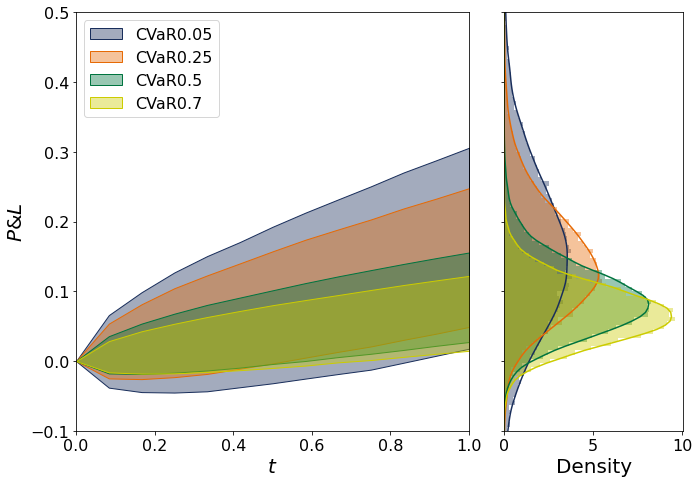

In [14]:
# get rewards instead of costs
rewards_total = x_paths[:,-1,:] - env.x0

# figure parameters
plt.rcParams.update({'font.size': 16, 'figure.figsize': (10,7)})
plt.rc('axes', labelsize=20)
fig = plt.figure()
gs = fig.add_gridspec(1,3)
ax_main = fig.add_subplot(gs[:-1])
ax_hist = fig.add_subplot(gs[-1], sharey=ax_main)

# plot the quantiles of the rewards through time
for idx, label in enumerate(pretrained_agents):
    ax_main.fill_between(x=env.t.numpy(),
                    y1=np.quantile(x_paths[:,:,idx].transpose() - env.x0, 0.1, axis=1),
                    y2=np.quantile(x_paths[:,:,idx].transpose() - env.x0, 0.9, axis=1),
                    facecolor=colors[idx]+(0.4,), edgecolor=colors[idx]+(1.0,),
                    linewidth=1.0)

ax_main.legend(pretrained_agents, loc="upper left")
ax_main.set_xlabel(r"$t$")
ax_main.set_ylabel(r"$P&L$")
ax_main.set_xlim(env.t[0], env.t[-1])

grid = np.linspace(-0.1, 0.5, 100)
for idx, label in enumerate(pretrained_agents):
    # plot histogram of terminal rewards and quantiles
    ax_hist.hist(x=x_paths[:,-1,idx] - env.x0, bins=grid,
            alpha=0.4, color=colors[idx], density=True, orientation='horizontal')

    # plot gaussian KDEs
    kde = gaussian_kde(x_paths[:,-1,idx] - env.x0, bw_method='silverman')
    ax_hist.plot(kde(grid), grid, color=colors[idx], linewidth=1.5)

ax_hist.set_xlabel("Density")
ax_hist.set_ylim(np.min(grid), np.max(grid))
plt.setp(ax_hist.get_yticklabels(), visible=False)

plt.tight_layout()
plt.show()